Loading functions

In [1]:
%load_ext autoreload
%autoreload 2

from utils import *
from dual import *

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### voice data prep

In [29]:
#voice_shuffle = pd.read_csv('voice.csv').sample(frac=1)
#save_file('voice_numsamp_shuffle_full', voice_shuffle)

In [2]:
def voice_prep(data, features):
    
    # Not taking random samples - using cumulative instead
    # data = data[:samples]  # data.sample(samples)
    
    data_size = len(data.index)

    voice_X = data.iloc[:, :-1]
    voice_y = data.iloc[:, -1]

    # code categories to -1/1
    gender_encoder = LabelEncoder()
    voice_y = np.array(gender_encoder.fit_transform(voice_y))
    voice_y = voice_y * 2 - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(voice_X)
    voice_X = np.array(scaler.transform(voice_X))
    voice_X = voice_X[:,0:features]
    
    return voice_X, voice_y

In [3]:
voice_shuffle = load_file('voice_numsamp_shuffle_full')
voice_X, voice_y = voice_prep(voice_shuffle, 2)

# Calculating rademacher for different bounds / margins

In [4]:
BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]) # np.array([0, 0.5, 1.0, 2.0])

numsamps = [50, 100, 200, 500, 1000, 2500]

runs_per_sample = 10
maxiter = 100
init_temp = 5500
accept = -5

pump_cycles = 1

In [5]:
# generate subsets

sets_x = []
sets_y = []
for numsamp in numsamps:
    PUMP_X = pd.DataFrame(voice_X).sample(numsamp, replace=False)
    PUMP_Y = voice_y[PUMP_X.index]

    PUMP_X = PUMP_X.values
    
    sets_x.append(PUMP_X)
    sets_y.append(PUMP_Y)
    
    save_file('vox'+str(numsamp), PUMP_X)
    save_file('voy'+str(numsamp), PUMP_Y)

In [5]:
for pc in range(pump_cycles):

    for numsamp in numsamps:
        
        PUMP_X = load_file('vox'+str(numsamp))
        PUMP_Y = load_file('voy'+str(numsamp))
    
        print('\n', numsamp, ':', pc, '///')
        
        for b in BOUNDS:
            
            # generate rademacher vector
            radvec = [rd.randint(0, 1) * 2 - 1 for x in range(numsamp)]
            
            ## Calculate Confidence Rademacher Complexity
            DATA_SAVE_NAME = "histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_confidence_b"+str(b)

            try:
                history = load_file(DATA_SAVE_NAME)
            except:
                print('creating new file')
                history = RDhistory('confidence')

            pump_rademacher(PUMP_X, PUMP_Y,
                            history=history,
                            radvec=radvec,
                            runs_per_sample=1,
                            margin=1.0, bound=b,
                            verbose=False)

            save_file(DATA_SAVE_NAME, history)

            ## Calculate Margin loss Rademacher Complexity for all the margins
            for mar in MARGINS:
                # print(mar, end=' ')
                
                # generate rademacher vector
                radvec = [rd.randint(0, 1) * 2 - 1 for x in range(numsamp)]

                DATA_SAVE_NAME = "histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar)

                try:
                    history = load_file(DATA_SAVE_NAME)
                except:
                    print('new file', end=' ')
                    history = RDhistory('margin_loss')

                pump_rademacher(PUMP_X, PUMP_Y,
                                history=history,
                                radvec=radvec,
                                runs_per_sample=runs_per_sample,
                                margin=mar, bound=b,
                                verbose=False,
                                method='da', kwargs={'maxiter':maxiter, 'initial_temp':init_temp, 'accept':accept})

                save_file(DATA_SAVE_NAME, history)


 50 : 0 ///

 100 : 0 ///

 200 : 0 ///

 500 : 0 ///

 1000 : 0 ///

 2500 : 0 ///


# Visualizing Rad. complexity vs number of  samples

0.07218414533603779
0.0467650848211189
0.03663887550923656
0.023338299771405887
0.015456741772870137
0.00973758111794796


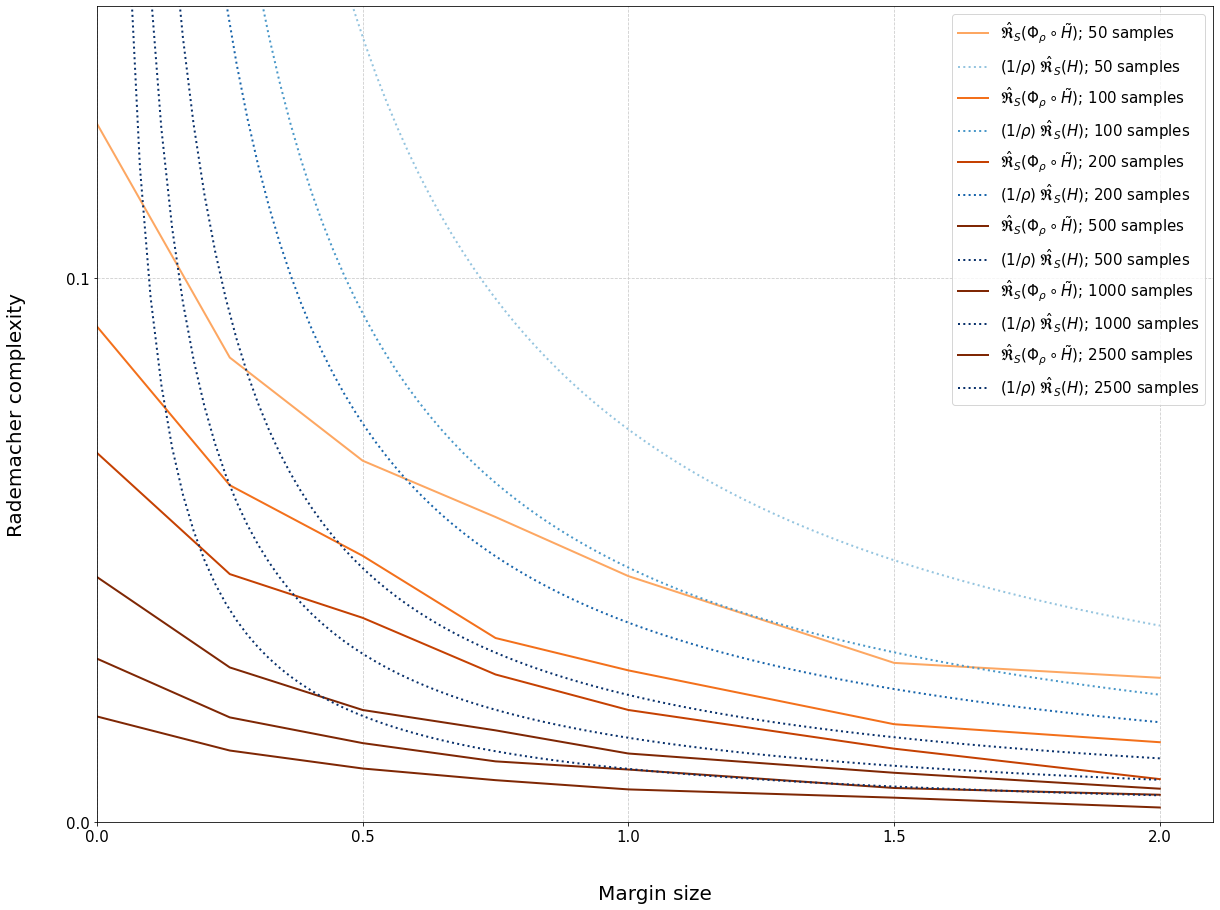

In [6]:
import matplotlib.cm as cm

BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]) # np.array([0, 0.5, 1.0, 2.0])
numsamps = [50, 100, 200, 500, 1000, 2500]

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, numsamp in enumerate(numsamps):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for b in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar))
            com.append(calc_complexity(h))
            
        linear_rad = calc_complexity( load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_confidence_b"+str(b)) )
        print(linear_rad)

        plt.plot(MARGINS, np.array(com), c=cmain, lw=2, label=r'$\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H})$; '+str(numsamp)+' samples')
        sp = np.linspace(0,2,100)
        yy = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        yy = np.insert(yy,0,None)
        plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\hat{\mathfrak{R}}_{S}(H)$; '+str(numsamp)+' samples', ls=':')

#   * np.sqrt(MARGINS) * np.sqrt(numsamp)

plt.ylim(0,0.15)
plt.xlim(0,2.1)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
#plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$ versus bound $((1/\rho)\;\mathfrak{R}_\mathfrak{m}(H))$', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMSAMP.png", bbox_inches='tight')

plt.show()


0.07218414533603779
0.0467650848211189
0.03663887550923656
0.023338299771405887
0.015456741772870137
0.00973758111794796


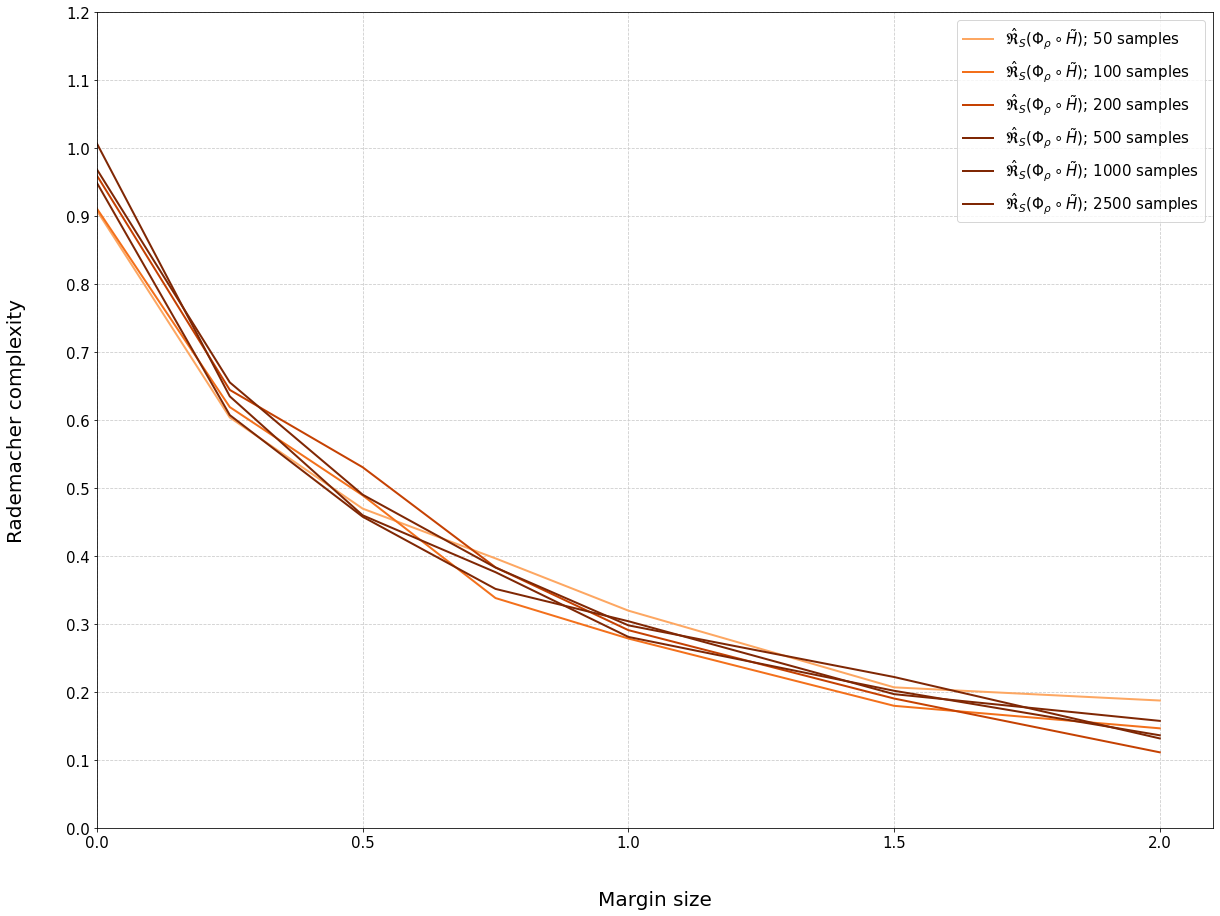

In [7]:
# import matplotlib.cm as cm

BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]) # np.array([0, 0.5, 1.0, 2.0])
numsamps = [50, 100, 200, 500, 1000, 2500]

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, numsamp in enumerate(numsamps):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for b in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar))
            com.append(calc_complexity(h))
            
        linear_rad = calc_complexity( load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_confidence_b"+str(b)) )
        print(linear_rad)

        plt.plot(MARGINS, np.array(com) * np.sqrt(numsamp), c=cmain, lw=2, label=r'$\hat{\mathfrak{R}}_{S}(\Phi_\rho \circ \tilde{H})$; '+str(numsamp)+' samples')
        #sp = np.linspace(0,2,100)
        #yy = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        #yy = np.insert(yy,0,None)
        #plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\mathfrak{R}_\mathfrak{m}(H)$; '+str(numsamp)+' samples', ls=':')

#   * np.sqrt(MARGINS) * np.sqrt(numsamp)

plt.ylim(0,1.2)
plt.xlim(0,2.1)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
#plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$, normalized by sample count', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMSAMP_rel.png", bbox_inches='tight')

plt.show()


0.07218414533603779
0.0467650848211189
0.03663887550923656
0.023338299771405887
0.015456741772870137
0.00973758111794796


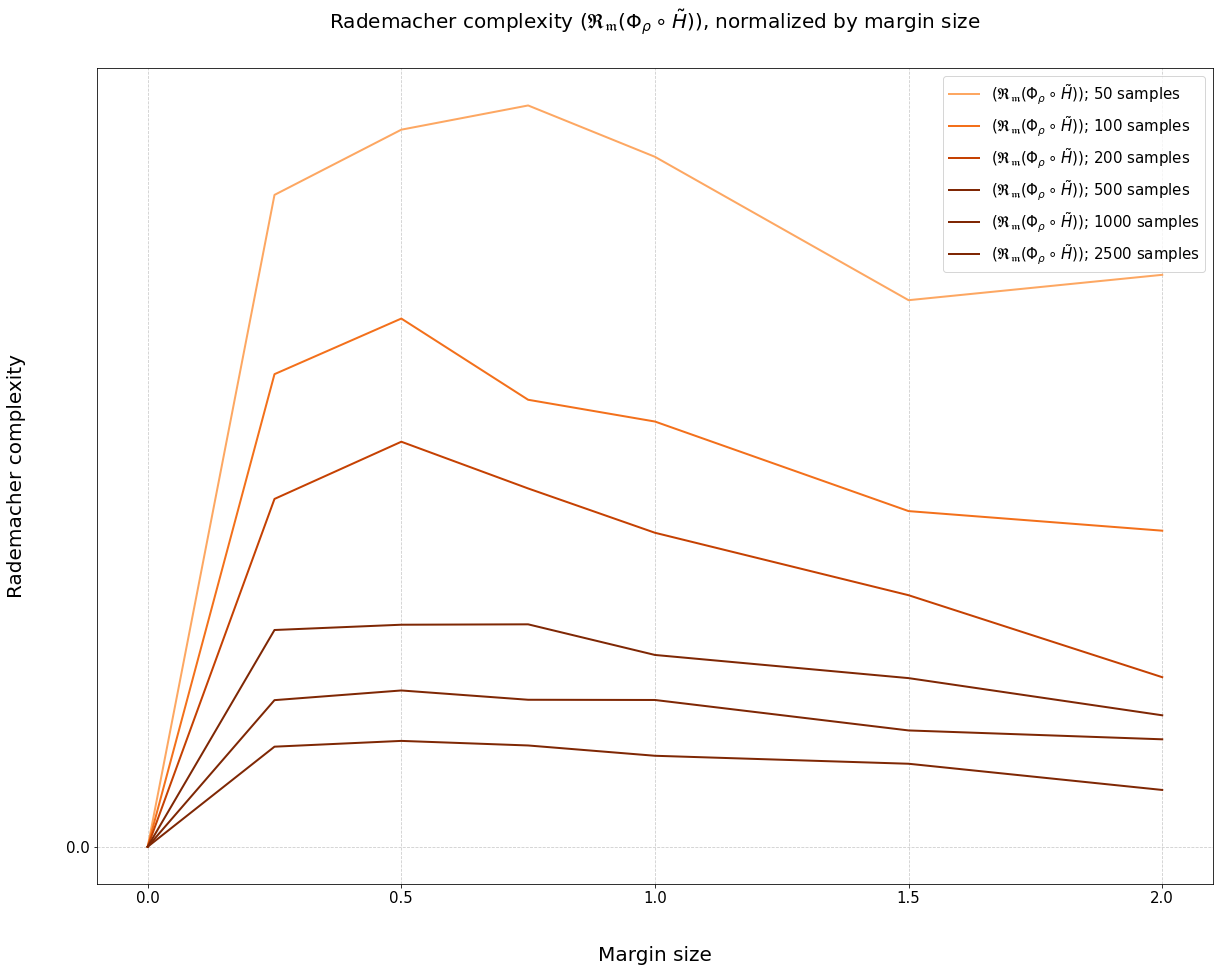

In [8]:
import matplotlib.cm as cm

BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]) # np.array([0, 0.5, 1.0, 2.0])
numsamps = [50, 100, 200, 500, 1000, 2500]

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, numsamp in enumerate(numsamps):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for b in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar))
            com.append(calc_complexity(h))
            
        linear_rad = calc_complexity( load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_confidence_b"+str(b)) )
        print(linear_rad)

        plt.plot(MARGINS, np.array(com) * np.sqrt(MARGINS), c=cmain, lw=2, label=r'$(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$; '+str(numsamp)+' samples')
        sp = np.linspace(0,2,100)
        yy = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        yy = np.insert(yy,0,None)
        #plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\mathfrak{R}_\mathfrak{m}(H)$; '+str(numsamp)+' samples', ls=':')

#   * np.sqrt(MARGINS) * np.sqrt(numsamp)

#plt.ylim(0,0.12)
#plt.xlim(-0.5,2.5)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$, normalized by margin size', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMSAMP_rel2.png")

plt.show()


0.07218414533603779
0.0467650848211189
0.03663887550923656
0.023338299771405887
0.015456741772870137
0.00973758111794796


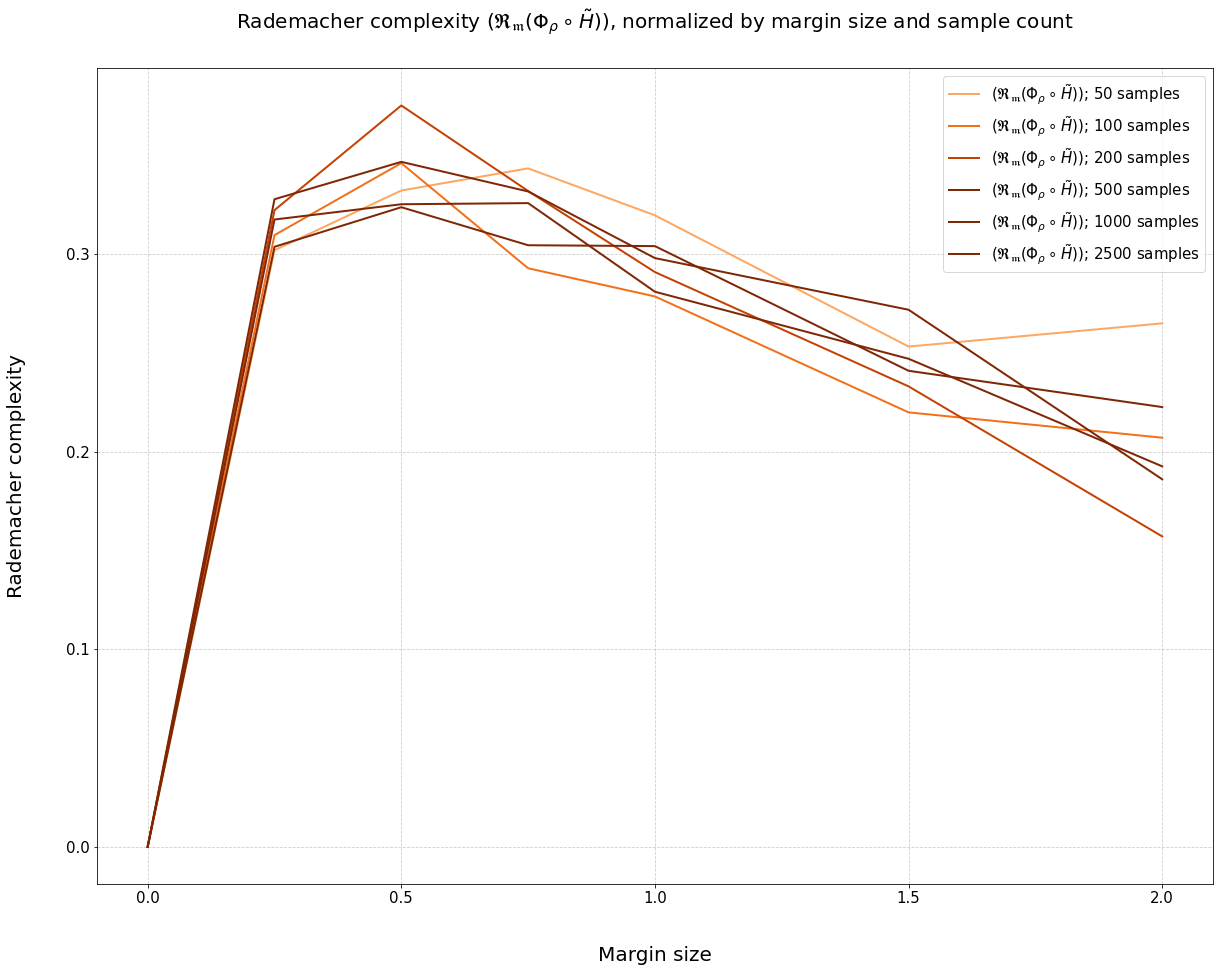

In [9]:
import matplotlib.cm as cm

BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]) # np.array([0, 0.5, 1.0, 2.0])
numsamps = [50, 100, 200, 500, 1000, 2500]

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.2
for index, numsamp in enumerate(numsamps):
    color_val += 0.2
    
    cmain = cm.Oranges(color_val)
    csub = cm.Blues(color_val)
    
    for b in BOUNDS: 
        com = []
        for mar in MARGINS:

            h = load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar))
            com.append(calc_complexity(h))
            
        linear_rad = calc_complexity( load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_confidence_b"+str(b)) )
        print(linear_rad)

        plt.plot(MARGINS, np.array(com) * np.sqrt(MARGINS) * np.sqrt(numsamp), c=cmain, lw=2, label=r'$(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$; '+str(numsamp)+' samples')
        sp = np.linspace(0,2,100)
        yy = np.ones(len(sp)-1)*(linear_rad)/sp[1:]
        yy = np.insert(yy,0,None)
        #plt.plot(sp, yy, lw=2, c=csub, label=r'$(1/\rho)\;\mathfrak{R}_\mathfrak{m}(H)$; '+str(numsamp)+' samples', ls=':')

#   * np.sqrt(MARGINS) * np.sqrt(numsamp)

#plt.ylim(0,0.12)
#plt.xlim(-0.5,2.5)

ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(AutoMinorLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper right')

plt.xlabel("Margin size", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$, normalized by margin size and sample count', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMSAMP_rel3.png")

plt.show()


### graph 2

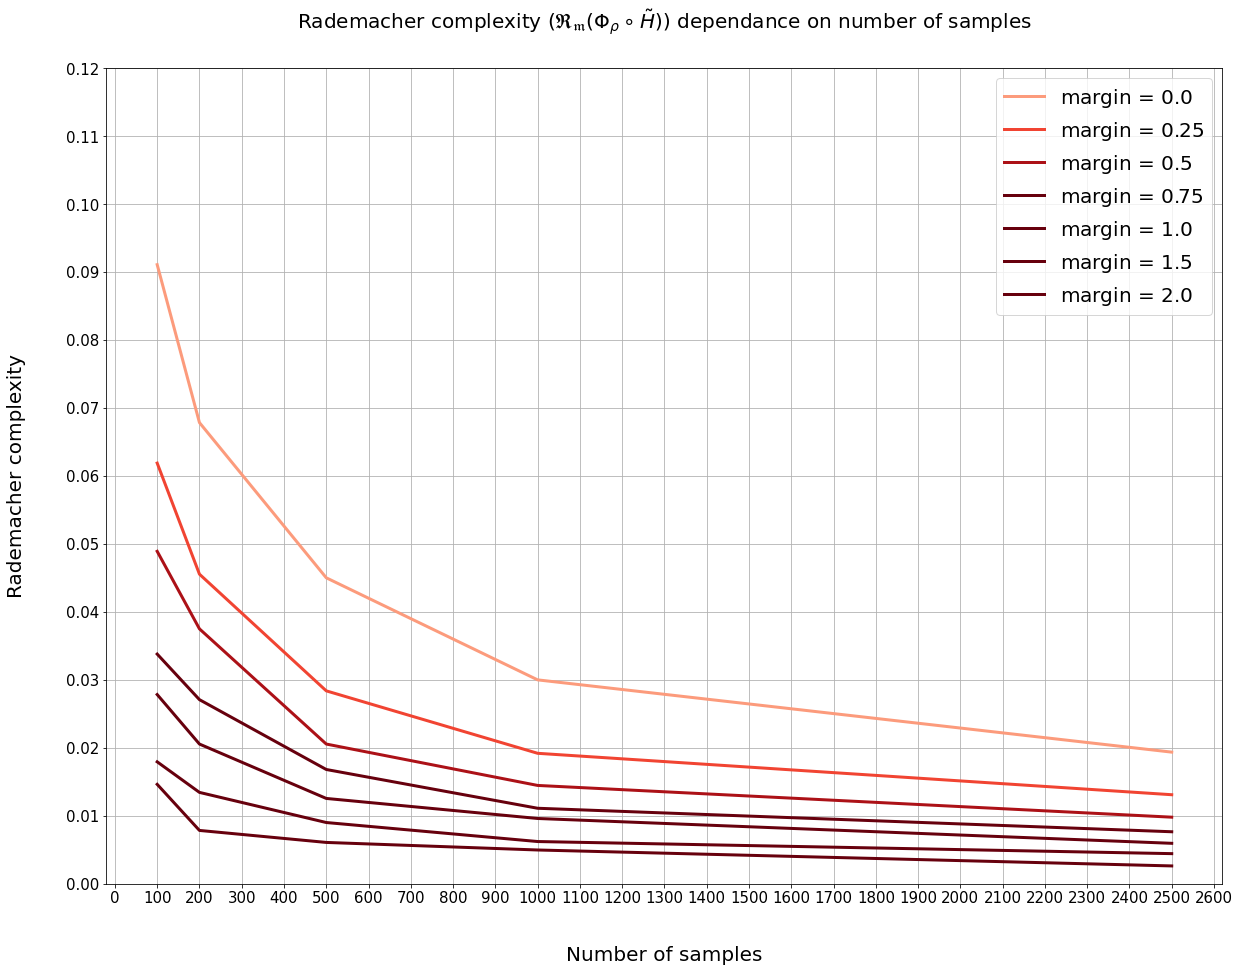

In [10]:
import matplotlib.cm as cm

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

BOUNDS = np.array([1e-12]) #, 0.5, 1.0])
MARGINS = np.array([0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0]) # np.array([0, 0.5, 1.0, 2.0])
numsamps = [50, 100, 200, 500, 1000, 2500]

fig, ax = plt.subplots(figsize=[20,15])

#plt.figure(figsize=[20,15])
color_val = 0.1


numsamps = [100, 200, 500, 1000, 2500]

for BOUND in BOUNDS:
    for mar in MARGINS:
        color_val += 0.25
        cmain = cm.Reds(color_val)        
        com = []
        for numsamp in numsamps:
            h = load_file("histories/numsamp/voice_fix_set_"+str(numsamp)+"_maxiter100_margin_loss_b" + str(b) + '_m' + str(mar))
            com.append(calc_complexity(h))
        
        plt.plot(numsamps, com, c=cmain, lw=3, label=r'margin = $'+str(mar)+'$')


plt.ylim(0,0.12)
#plt.xlim(-0.5,2.5)

#ax.minorticks_on()
ax.grid(True, which='both')

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.01))

#ax.xaxis.set_minor_locator(AutoMinorLocator(100))
#ax.yaxis.set_minor_locator(AutoMinorLocator(0.05))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
#ax.grid(which='major', color='#CCCCCC', linestyle='--')
#ax.grid(which='minor', color='#CCCCCC', linestyle=':',lw=3)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)

plt.xlabel("Number of samples", fontsize=20, labelpad=40)
plt.ylabel("Rademacher complexity", fontsize=20, labelpad=40)
plt.title(r'Rademacher complexity $(\mathfrak{R}_\mathfrak{m}(\Phi_\rho \circ \tilde{H}))$ dependance on number of samples', fontsize=20, pad=40)

plt.savefig("images/VOICE_NUMSAMP2.png")

plt.show()
